## Imports

In [40]:
# for Data Manipulation
import pandas as pd
import numpy as np
import os
import csv 

# for EDA
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline   
from collections import Counter

# for NLP
from textatistic import Textatistic
import spacy
from spacy import displacy

# for Statistics
from scipy import stats

# Parallelization
import swifter

## Check Data

In [5]:
df = pd.read_csv('politifact_ner_cleaned_data.csv')
# Option to extend the dataframe to the full width
pd.set_option('display.max_colwidth', 200)
df.head()

,statement,source,veracity,date
0,"Sen. Kamala Harris is ""supporting the animals of MS-13.""",Donald Trump,0,2018-07-03
1,"Says Ronald Reagan said immigrants ""brought with them courage and the values of family, work, and freedom. Let us pledge to each other that we can make America great again.""",Becoming American Initiative,1,2018-07-03
2,"Says Democratic Senators ""demand Supreme Court nominee not be unduly influenced by U.S. Constitution.""",Viral image,0,2018-07-03
3,"""Tim Kaine doesn’t want a border at all. He wants to get rid of Immigration and Customs Enforcement and basically the border patrol as well.""",Corey Stewart,0,2018-07-03
4,"""George H.W. Bush has died at 94.""",Bloggers,0,2018-07-02


In [6]:
df.veracity.value_counts()

0    6335
1    4853
Name: veracity, dtype: int64

## Import lemmatized data

This dataset was created in the previous notebook. It contains the cleaned politifact dataset, alongside the lemmatized version of statements.

In [11]:
df = pd.read_csv("politifact_ner_cleaned_lemmas.csv")
df.head()

,statement,source,veracity,date,lemmas
0,"Sen. Kamala Harris is ""supporting the animals of MS-13.""",Donald Trump,0,2018-07-03,kamala harris support animal
1,"Says Ronald Reagan said immigrants ""brought with them courage and the values of family, work, and freedom. Let us pledge to each other that we can make America great again.""",Becoming American Initiative,1,2018-07-03,ronald reagan immigrant bring courage value family work freedom let pledge america great
2,"Says Democratic Senators ""demand Supreme Court nominee not be unduly influenced by U.S. Constitution.""",Viral image,0,2018-07-03,democratic senators demand supreme court nominee unduly influence constitution
3,"""Tim Kaine doesn’t want a border at all. He wants to get rid of Immigration and Customs Enforcement and basically the border patrol as well.""",Corey Stewart,0,2018-07-03,tim kaine want border want rid immigration customs enforcement basically border patrol
4,"""George H.W. Bush has died at 94.""",Bloggers,0,2018-07-02,george bush die


In [8]:
df.shape

(11188, 5)

## Import feature engineered DataFrame from previous notebook

In [9]:
# df = pd.read_csv("politifact_ner_automatic_pos_tag_counts.csv")
# df[:2]

,source,veracity,date,lemmas,numb_of_letters,numb_of_words,avg_word_len,read_score_gun,pos_tags,count_of_adjective,...,count_of_punctuation,freq_of_punctuation,count_of_space,freq_of_space,count_of_symbol,freq_of_symbol,count_of_verb,freq_of_verb,count_of_unknown,freq_of_unknown
0,Donald Trump,0,2018-07-03,kamala harris support animal,56,9,5.3,10.0,"[('Sen.', 'PROPN'), ('Kamala', 'PROPN'), ('Harris', 'PROPN'), ('is', 'AUX'), ('""', 'PUNCT'), ('supporting', 'VERB'), ('the', 'DET'), ('animals', 'NOUN'), ('of', 'ADP'), ('MS-13', 'PROPN'), ('.', '...",0,...,3,0.333333,0,0.000000,0,0.0,1,0.111111,0,0.0
1,Becoming American Initiative,1,2018-07-03,ronald reagan immigrant bring courage value family work freedom let pledge america great,173,30,4.8,7.3,"[('Says', 'VERB'), ('Ronald', 'PROPN'), ('Reagan', 'PROPN'), ('said', 'VERB'), ('immigrants', 'NOUN'), ('\xa0', 'SPACE'), ('""', 'PUNCT'), ('brought', 'VERB'), ('with', 'ADP'), ('them', 'PRON'), ('...",2,...,6,0.200000,1,0.033333,0,0.0,6,0.200000,0,0.0


In [10]:
# df.columns

Index(['source', 'veracity', 'date', 'lemmas', 'numb_of_letters',
       'numb_of_words', 'avg_word_len', 'read_score_gun', 'pos_tags',
       'count_of_adjective', 'freq_of_adjective',
       'count_of_conjunction or particle or adverb',
       'freq_of_conjunction or particle or adverb', 'count_of_adverb',
       'freq_of_adverb', 'count_of_coordinating conjuction',
       'freq_of_coordinating conjuction', 'count_of_determiner',
       'freq_of_determiner', 'count_of_interjection', 'freq_of_interjection',
       'count_of_noun', 'freq_of_noun', 'count_of_number', 'freq_of_number',
       'count_of_possessive', 'freq_of_possessive', 'count_of_pronoun',
       'freq_of_pronoun', 'count_of_proper noun', 'freq_of_proper noun',
       'count_of_punctuation', 'freq_of_punctuation', 'count_of_space',
       'freq_of_space', 'count_of_symbol', 'freq_of_symbol', 'count_of_verb',
       'freq_of_verb', 'count_of_unknown', 'freq_of_unknown'],
      dtype='object')

## POS (Part of Speech) Tagging (simple version, also used in previous notebook)

Current method of POS tagging involved the use of 16 tags, being the simple version variant of POS tagging.

In [12]:
nlp = spacy.load('en_core_web_lg')

In [13]:
# First sample
nobj = nlp(df.statement[0])
pos = [(token.text, token.pos_) for token in nobj]
print(pos)

[('Sen.', 'PROPN'), ('Kamala', 'PROPN'), ('Harris', 'PROPN'), ('is', 'AUX'), ('"', 'PUNCT'), ('supporting', 'VERB'), ('the', 'DET'), ('animals', 'NOUN'), ('of', 'ADP'), ('MS-13', 'PROPN'), ('.', 'PUNCT'), ('"', 'PUNCT')]


In [14]:
# POS tagger function
def pos_tagger(text):
    
    # nlp object
    nobj = nlp(text)
    
    # POS tags
    tagged_text = [(token.text, token.pos_) for token in nobj]
    
    # tagged text
    return tagged_text

In [15]:
# Create a column with the POS tags for each statement

df["general_pos_tags"] = df["statement"].apply(pos_tagger)

In [16]:
# Check that our column was properly created
df[["general_pos_tags"]][0:5]

,general_pos_tags
0,"[(Sen., PROPN), (Kamala, PROPN), (Harris, PROPN), (is, AUX), ("", PUNCT), (supporting, VERB), (the, DET), (animals, NOUN), (of, ADP), (MS-13, PROPN), (., PUNCT), ("", PUNCT)]"
1,"[(Says, VERB), (Ronald, PROPN), (Reagan, PROPN), (said, VERB), (immigrants, NOUN), ( , SPACE), ("", PUNCT), (brought, VERB), (with, ADP), (them, PRON), (courage, NOUN), (and, CCONJ), (the, DET), (v..."
2,"[(Says, VERB), (Democratic, ADJ), (Senators, PROPN), ("", PUNCT), (demand, VERB), (Supreme, PROPN), (Court, PROPN), (nominee, NOUN), (not, PART), (be, AUX), (unduly, ADV), (influenced, VERB), (by, ..."
3,"[("", PUNCT), (Tim, PROPN), (Kaine, PROPN), (does, AUX), (n’t, PART), (want, VERB), (a, DET), (border, NOUN), (at, ADV), (all, ADV), (., PUNCT), (He, PRON), (wants, VERB), (to, PART), (get, AUX), (..."
4,"[("", PUNCT), (George, PROPN), (H.W., PROPN), (Bush, PROPN), (has, AUX), (died, VERB), (at, ADP), (94, NUM), (., PUNCT), ("", PUNCT)]"


In [17]:
# Intuitive vizualization of how the POS tagger works
displacy.render(nobj, 
                options = {
                          "distance" : 100,
                          "arrow_stroke" : 3, # thickness of arrow line
                          "arrow_width" : 8, # thickness of arrow head
                          "font" : "Helvetica", # font
                          "bg" : "#ADD8E6" # background color
                         })

## Advanced POS (Part of Speech) Tagging

The Advanced POS actually identifies specific parts of speech, which in turn includes 53 labels, as opposed to 16.

The **tag_** field uses Penn Treebank tag set. More details [here](https://www.sketchengine.eu/penn-treebank-tagset/). 

In [18]:
# POS Advanced Tagging using .tag_ (Specific POS tagging)
nobj = nlp(df.statement[2])
pos = [(token.text, token.tag_) for token in nobj]
print(pos)

[('Says', 'VBZ'), ('Democratic', 'JJ'), ('Senators', 'NNPS'), ('"', "''"), ('demand', 'VBP'), ('Supreme', 'NNP'), ('Court', 'NNP'), ('nominee', 'NN'), ('not', 'RB'), ('be', 'VB'), ('unduly', 'RB'), ('influenced', 'VBN'), ('by', 'IN'), ('U.S.', 'NNP'), ('Constitution', 'NNP'), ('.', '.'), ('"', "''")]


In [19]:
def tag_tagger(text):
    
    # nlp object
    nobj = nlp(text)
    
    # tags
    tagged_text = [(token.text, token.tag_) for token in nobj]
    
    # tagged text
    return tagged_text

In [20]:
# Apply the tagger on statements and store the results in a new column
# We use Swifter to parallelize operations. Should take around a few minutes (depending on number of cores)

df["specific_pos_tags"] = df["statement"].swifter.apply(tag_tagger)

In [21]:
# Check that the data was transformed correctly
df[["specific_pos_tags"]][0:5]

,specific_pos_tags
0,"[(Sen., NNP), (Kamala, NNP), (Harris, NNP), (is, VBZ), ("", ``), (supporting, VBG), (the, DT), (animals, NNS), (of, IN), (MS-13, CD), (., .), ("", '')]"
1,"[(Says, VBZ), (Ronald, NNP), (Reagan, NNP), (said, VBD), (immigrants, NNS), ( , _SP), ("", ``), (brought, VBN), (with, IN), (them, PRP), (courage, NN), (and, CC), (the, DT), (values, NNS), (of, IN)..."
2,"[(Says, VBZ), (Democratic, JJ), (Senators, NNPS), ("", ''), (demand, VBP), (Supreme, NNP), (Court, NNP), (nominee, NN), (not, RB), (be, VB), (unduly, RB), (influenced, VBN), (by, IN), (U.S., NNP), ..."
3,"[("", ``), (Tim, NNP), (Kaine, NNP), (does, VBZ), (n’t, RB), (want, VB), (a, DT), (border, NN), (at, RB), (all, RB), (., .), (He, PRP), (wants, VBZ), (to, TO), (get, VB), (rid, VBN), (of, IN), (Imm..."
4,"[("", ``), (George, NNP), (H.W., NNP), (Bush, NNP), (has, VBZ), (died, VBN), (at, IN), (94, CD), (., .), ("", '')]"


In [22]:
# In case we wish to save progress up until now
df.to_csv('politifact_pos_advanced.csv', index=False)

## POS lists and dictionaries based on tags

### Creating list and dict for "pos_" field (16 entries)

In [23]:
# We create a list of all Parts of Speech, as used in Spacy
# Didn't include the POS entry, which contains the description
# Source: https://web.archive.org/web/20201207014953/https://spacy.io/api/annotation

list_pos = [ ('ADJ', 'adjective'),
             ('ADP', 'conjunction or particle or adverb'),
             ('ADV', 'adverb'),
             ('CCONJ', 'coordinating conjuction'),
             ('DET', 'determiner'),
             ('INTJ', 'interjection'),
             ('NOUN', 'noun'),
             ('NUM', 'number'),
             ('PART', 'possessive'),
             ('PRON', 'pronoun'),
             ('PROPN', 'proper noun'),
             ('PUNCT', 'punctuation'),
             ('SPACE', 'space'),
             ('SYM', 'symbol'),
             ('VERB', 'verb'),
             ('X', 'unknown')]

In [24]:
# Create a dict from our list for speed of indexing
mydict_pos = {}
for (k, v) in list_pos:
    mydict_pos[k] = v
mydict_pos

{'ADJ': 'adjective',
 'ADP': 'conjunction or particle or adverb',
 'ADV': 'adverb',
 'CCONJ': 'coordinating conjuction',
 'DET': 'determiner',
 'INTJ': 'interjection',
 'NOUN': 'noun',
 'NUM': 'number',
 'PART': 'possessive',
 'PRON': 'pronoun',
 'PROPN': 'proper noun',
 'PUNCT': 'punctuation',
 'SPACE': 'space',
 'SYM': 'symbol',
 'VERB': 'verb',
 'X': 'unknown'}

In [25]:
dot_pos_list = list(mydict_pos.keys())
print(list_pos[0:])

[('ADJ', 'adjective'), ('ADP', 'conjunction or particle or adverb'), ('ADV', 'adverb'), ('CCONJ', 'coordinating conjuction'), ('DET', 'determiner'), ('INTJ', 'interjection'), ('NOUN', 'noun'), ('NUM', 'number'), ('PART', 'possessive'), ('PRON', 'pronoun'), ('PROPN', 'proper noun'), ('PUNCT', 'punctuation'), ('SPACE', 'space'), ('SYM', 'symbol'), ('VERB', 'verb'), ('X', 'unknown')]


### Creating list and dict for "tag_" field (53 entries)

In [26]:
# Copied the table and created a csv for ease of use
# Source: https://web.archive.org/web/20201207014953/https://spacy.io/api/annotation

dot_tag_df = pd.read_csv("pos_tags_specific.csv")
dot_tag_df[["TAG","DESCRIPTION"]][0:2]

,TAG,DESCRIPTION
0,$,"symbol, currency"
1,``,opening quotation mark


In [27]:
len(dot_tag_df)

53

In [28]:
tags = dot_tag_df['TAG'].tolist()
descr = dot_tag_df['DESCRIPTION'].tolist()
print(len(tags), len(descr))


53 53


In [29]:
mydict_tag = {}
for i in range(len(tags)):
    mydict_tag[tags[i]] = descr[i]
    
mydict_tag

{'$': 'symbol, currency',
 '``': 'opening quotation mark',
 "''": 'closing quotation mark',
 ',': 'punctuation mark, comma',
 '-LRB-': 'left round bracket',
 '-RRB-': 'right round bracket',
 '.': 'punctuation mark, sentence closer',
 ':': 'punctuation mark, colon or ellipsis',
 'ADD': 'email',
 'AFX': 'affix',
 'CC': 'conjunction, coordinating',
 'CD': 'cardinal number',
 'DT': 'determiner',
 'EX': 'existential there',
 'FW': 'foreign word',
 'GW': 'additional word in multi-word expression',
 'HYPH': 'punctuation mark, hyphen',
 'IN': 'conjunction, subordinating or preposition',
 'JJ': 'adjective',
 'JJR': 'adjective, comparative',
 'JJS': 'adjective, superlative',
 'LS': 'list item marker',
 'MD': 'verb, modal auxiliary',
 'NFP': 'superfluous punctuation',
 'NIL': 'missing tag',
 'NN': 'noun, singular or mass',
 'NNP': 'noun, proper singular',
 'NNPS': 'noun, proper plural',
 'NNS': 'noun, plural',
 'PDT': 'predeterminer',
 'POS': 'possessive ending',
 'PRP': 'pronoun, personal',
 'PR

In [30]:
list(mydict_tag.items())[8:11]

[('ADD', 'email'), ('AFX', 'affix'), ('CC', 'conjunction, coordinating')]

In [31]:
dot_tag_list = list(mydict_tag.keys())
print(dot_tag_list[5:10])

['-RRB-', '.', ':', 'ADD', 'AFX']


## Automatic POS (pos_ and tag_) counts

In [32]:
def dot_pos_counter(text, p):
    
    # nlp object
    nobj = nlp(text)
    
    # list of POS tags
    pos = [token.pos_ for token in nobj]
    
    # count POS
    return pos.count(p)

In [33]:
# loop through the list of .pos_ tags and create new columns with counts for each tag
# We use Swifter to parallelize operations. Should take less than 30 minutes (depending on number of cores)
# We iterate through the 53 entries of the pos_ attribute

for p in dot_pos_list:
    df[("pos_"+mydict_pos[p])] = df["statement"].swifter.apply(lambda x : dot_pos_counter(x, p))

In [34]:
def dot_tag_counter(text, t):
    
    # nlp object
    nobj = nlp(text)
    
    # list of tags
    tg = [token.tag_ for token in nobj]
    
    # count
    return tg.count(t)

In [41]:
# loop through the list of .tag_ tags and create new columns with counts for each tag
# We use Swifter to parallelize operations. Should take about 2 hours (depending on number of cores)
# We iterate through the 53 entries of the tag_ attribute

for t in dot_tag_list:
    df[("tag_"+str(mydict_tag[t]))] = df["statement"].swifter.apply(lambda x : dot_tag_counter(x, t))

In [42]:
# to see df in full
pd.set_option('display.max_columns', 200) 

df.head(1)

,statement,source,veracity,date,lemmas,general_pos_tags,specific_pos_tags,pos_adjective,pos_conjunction or particle or adverb,pos_adverb,pos_coordinating conjuction,pos_determiner,pos_interjection,pos_noun,pos_number,pos_possessive,pos_pronoun,pos_proper noun,pos_punctuation,pos_space,pos_symbol,pos_verb,pos_unknown,"tag_symbol, currency",tag_opening quotation mark,tag_closing quotation mark,"tag_punctuation mark, comma",tag_left round bracket,tag_right round bracket,"tag_punctuation mark, sentence closer","tag_punctuation mark, colon or ellipsis",tag_email,tag_affix,"tag_conjunction, coordinating",tag_cardinal number,tag_determiner,tag_existential there,tag_foreign word,tag_additional word in multi-word expression,"tag_punctuation mark, hyphen","tag_conjunction, subordinating or preposition",tag_adjective,"tag_adjective, comparative","tag_adjective, superlative",tag_list item marker,"tag_verb, modal auxiliary",tag_superfluous punctuation,tag_missing tag,"tag_noun, singular or mass","tag_noun, proper singular","tag_noun, proper plural","tag_noun, plural",tag_predeterminer,tag_possessive ending,"tag_pronoun, personal","tag_pronoun, possessive",tag_adverb,"tag_adverb, comparative","tag_adverb, superlative","tag_adverb, particle",tag_space,tag_symbol,"tag_infinitival ""to""",tag_interjection,"tag_verb, base form","tag_verb, past tense","tag_verb, gerund or present participle","tag_verb, past participle","tag_verb, non-3rd person singular present","tag_verb, 3rd person singular present",tag_wh-determiner,"tag_wh-pronoun, personal","tag_wh-pronoun, possessive",tag_wh-adverb,tag_unknown,tag_nan
0,"Sen. Kamala Harris is ""supporting the animals of MS-13.""",Donald Trump,0,2018-07-03,kamala harris support animal,"[(Sen., PROPN), (Kamala, PROPN), (Harris, PROPN), (is, AUX), ("", PUNCT), (supporting, VERB), (the, DET), (animals, NOUN), (of, ADP), (MS-13, PROPN), (., PUNCT), ("", PUNCT)]","[(Sen., NNP), (Kamala, NNP), (Harris, NNP), (is, VBZ), ("", ``), (supporting, VBG), (the, DT), (animals, NNS), (of, IN), (MS-13, CD), (., .), ("", '')]",0,1,0,0,1,0,1,1,0,0,3,3,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


## POS Statistics

In [52]:
""" 
since the tvsf function output would be difficult to read, let's convert to a dataframe output
"""

# func for comparing truth vs lie
def df_tvsf(tag_type, column_dict, index_list):
    #ex: df_tvsf("pos_", mydict_pos, dot_pos_list)
    
    d = []
    for x in index_list:
        
        # t & f variables
        
        truths = df[df['veracity'] == 1][tag_type+str(column_dict[x])]
        falsehoods = df[df['veracity'] == 0][tag_type+str(column_dict[x])]

        # means
        truths_mean = round(truths.mean(), 2)
        falsehoods_mean = round(falsehoods.mean(), 2)

        # t-test
        t,p = stats.ttest_ind(truths,
                              falsehoods, 
                              equal_var = False)
        # dataframe
        d.append({'t_means' : truths_mean, 
                  'f_means' : falsehoods_mean, 
                  'p_value' : round(p,3)})
        
    return pd.DataFrame(d, index = column_dict.values())[['t_means', 'f_means', 'p_value']]

### pos_ property

In [37]:
# return df with probability values that approach or are significant
dot_pos_df = df_tvsf("pos_", mydict_pos, dot_pos_list)
dot_pos_df[dot_pos_df.p_value < 0.05]

,t_means,f_means,p_value
adjective,1.37,1.13,0.000
conjunction or particle or adverb,2.27,2.04,0.000
adverb,0.70,0.59,0.000
coordinating conjuction,0.37,0.33,0.004
determiner,1.83,1.64,0.000
interjection,0.00,0.01,0.007
noun,4.35,3.96,0.000
number,0.96,0.64,0.000
possessive,0.49,0.60,0.000
proper noun,2.02,2.51,0.000


#### Conclusions:

More present in TRUTHS as opposed to LIES: Adjectives, Determiners, Conjunctions, Adverbs, Nouns, Numbers. Might imply more details, more precision in affirmations.

More present in LIES as opposed to TRUTHS: Possesiveness and proper nouns. Might imply speech about other people or a focus on oneself.

### tag_ property

In [53]:
# return df with probability values that approach or are significant
dot_pos_df = df_tvsf("tag_", mydict_tag, dot_tag_list)
dot_pos_df[dot_pos_df.p_value < 0.05]

,t_means,f_means,p_value
"symbol, currency",0.13,0.11,0.039
opening quotation mark,0.85,0.88,0.004
closing quotation mark,1.04,1.12,0.000
"punctuation mark, comma",0.54,0.49,0.000
"punctuation mark, sentence closer",1.12,1.09,0.009
"conjunction, coordinating",0.37,0.33,0.004
cardinal number,0.96,0.64,0.000
determiner,1.72,1.53,0.000
"punctuation mark, hyphen",0.15,0.14,0.049
"conjunction, subordinating or preposition",2.59,2.24,0.000


#### Conclusions

More present in TRUTHS as opposed to LIES: Cardinal number, Determiner, Adjectives, Conjunction, Noun, Adverbs, verb 3rd person non singular.

More present in LIES as opposed to TRUTHS: Infinitval 'to', verbs in their base form, verbs in past tense, verbs, 3rd person singular.

## Named Entity Recognition (NER) Tagging

In [ ]:
# NER example
displacy.render(nobj, style="ent")

In [ ]:
# NER tagger function that creates a list of all tags within a statement
def ner_tagger(text):
    
    # nlp object
    nobj = nlp(text)
    
    # ner tags
    ne = [(ent.text, ent.label_) for ent in nobj.ents]

    return ne

In [ ]:
# Apply the tagger on statements and store the results in a new column
df["ner_tags"] = df["statement"].swifter.apply(ner_tagger)

In [ ]:
# Check that the data was transformed correctly
df[["ner_tags"]][0:5]

In [25]:
# In case we wish to save progress up until now
# df.to_csv('politifact_pos_advanced_ner.csv', index=False)

## NER lists and dictionaries based on tags

In [54]:
# We create a dictionary of all the possbile Entities within Spacy
# Source: https://web.archive.org/web/20201207014953/https://spacy.io/api/annotation
# Full information found within "ner.csv"

mydict_ner = {
    "PERSON" : "people",
    "NORP" : "groups",
    "FAC" : "facilities",
    "ORG" : "organizations",
    "GPE" : "regions",
    "LOC" : "landmarks",
    "PRODUCT" : "products",
    "EVENT" : "events",
    "WORK_OF_ART" : "art",
    "LAW" : "laws",
    "LANGUAGE" : "languages",
    "DATE" : "dates",
    "TIME" : "times",
    "PERCENT" : "percentages",
    "MONEY" : "money",
    "QUANTITY" : "quantity",
    "ORDINAL" : "ordinality",
    "CARDINAL" : "numerals" 
}

In [55]:
# preview dict
list(mydict_ner.items())[0:5]

[('PERSON', 'people'),
 ('NORP', 'groups'),
 ('FAC', 'facilities'),
 ('ORG', 'organizations'),
 ('GPE', 'regions')]

In [56]:
ner_list = list(mydict_ner.keys())

In [57]:
def ner_counter(text, n):
    # nlp object
    nobj = nlp(text)
    # list of POS tags
    ne = [ent.label_ for ent in nobj.ents]
    # no. of proper nouns
    return ne.count(n)

### Create new columns for each NER tag

In [58]:
# to loop through the list of NER tags and create new columns with counts for each tag
# We use Swifter to parallelize operations. Should take less than 30 minutes (depending on number of cores).
for n in ner_list:
    # df[n] = df.statement.apply(lambda x : proper_nouns(x, n)) #this works
    df[("ner_"+str(mydict_ner[n]))] = df["statement"].swifter.apply(lambda x : ner_counter(x, n))

In [59]:
df.head(1)

,statement,source,veracity,date,lemmas,general_pos_tags,specific_pos_tags,pos_adjective,pos_conjunction or particle or adverb,pos_adverb,pos_coordinating conjuction,pos_determiner,pos_interjection,pos_noun,pos_number,pos_possessive,pos_pronoun,pos_proper noun,pos_punctuation,pos_space,pos_symbol,pos_verb,pos_unknown,"tag_symbol, currency",tag_opening quotation mark,tag_closing quotation mark,"tag_punctuation mark, comma",tag_left round bracket,tag_right round bracket,"tag_punctuation mark, sentence closer","tag_punctuation mark, colon or ellipsis",tag_email,tag_affix,"tag_conjunction, coordinating",tag_cardinal number,tag_determiner,tag_existential there,tag_foreign word,tag_additional word in multi-word expression,"tag_punctuation mark, hyphen","tag_conjunction, subordinating or preposition",tag_adjective,"tag_adjective, comparative","tag_adjective, superlative",tag_list item marker,"tag_verb, modal auxiliary",tag_superfluous punctuation,tag_missing tag,"tag_noun, singular or mass","tag_noun, proper singular","tag_noun, proper plural","tag_noun, plural",tag_predeterminer,tag_possessive ending,"tag_pronoun, personal","tag_pronoun, possessive",tag_adverb,"tag_adverb, comparative","tag_adverb, superlative","tag_adverb, particle",tag_space,tag_symbol,"tag_infinitival ""to""",tag_interjection,"tag_verb, base form","tag_verb, past tense","tag_verb, gerund or present participle","tag_verb, past participle","tag_verb, non-3rd person singular present","tag_verb, 3rd person singular present",tag_wh-determiner,"tag_wh-pronoun, personal","tag_wh-pronoun, possessive",tag_wh-adverb,tag_unknown,tag_nan,ner_people,ner_groups,ner_facilities,ner_organizations,ner_regions,ner_landmarks,ner_products,ner_events,ner_art,ner_laws,ner_languages,ner_dates,ner_times,ner_percentages,ner_money,ner_quantity,ner_ordinality,ner_numerals
0,"Sen. Kamala Harris is ""supporting the animals of MS-13.""",Donald Trump,0,2018-07-03,kamala harris support animal,"[(Sen., PROPN), (Kamala, PROPN), (Harris, PROPN), (is, AUX), ("", PUNCT), (supporting, VERB), (the, DET), (animals, NOUN), (of, ADP), (MS-13, PROPN), (., PUNCT), ("", PUNCT)]","[(Sen., NNP), (Kamala, NNP), (Harris, NNP), (is, VBZ), ("", ``), (supporting, VBG), (the, DT), (animals, NNS), (of, IN), (MS-13, CD), (., .), ("", '')]",0,1,0,0,1,0,1,1,0,0,3,3,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## NER Statistics

In [60]:
# return df with probability values that approach or are significant
ner_df = df_tvsf("ner_", mydict_ner, ner_list)
ner_df[ner_df.p_value < 0.05]

,t_means,f_means,p_value
people,0.35,0.51,0.000
organizations,0.27,0.34,0.000
regions,0.44,0.39,0.000
art,0.01,0.02,0.000
dates,0.32,0.19,0.000
percentages,0.16,0.09,0.000
money,0.15,0.12,0.004
ordinality,0.05,0.03,0.000
numerals,0.31,0.20,0.000


In [61]:
len(ner_df)

18

#### Conclusions

More present in TRUTH as opposed to LIES: Dates, Numerals, ordinality and regions. This might imply more precision and details in statements.

More present in LIES as opposed to TRUTHS: People, organizations. This might imply more hearsay and accusations. 

## Syntactic Dependency (SD) tagging

In [26]:
# Syntactic Dependency .dep_ example
nobj = nlp(df.statement[21])
sd = [(token.text, token.dep_) for token in nobj]
print(sd)

[('Says', 'ROOT'), ('Republican', 'amod'), ('gubernatorial', 'amod'), ('candidate', 'compound'), ('Adam', 'compound'), ('Laxalt', 'nsubj'), ('"', 'punct'), ('tried', 'ccomp'), ('to', 'aux'), ('cut', 'xcomp'), ('a', 'det'), ('deal', 'dobj'), ('with', 'prep'), ('big', 'amod'), ('pharma', 'pobj'), ('"', 'punct'), ('in', 'prep'), ('a', 'det'), ('lawsuit', 'pobj'), ('.', 'punct')]


In [27]:
# Syntactic Dependency tagger function
def sd_tagger(text):
    
    # nlp object
    nobj = nlp(text)
    
    # tags list
    tagged_text = [(token.text, token.dep_) for token in nobj]
    
    return tagged_text

In [28]:
# Apply the tagger on statements and store the results in a new column
df["sd_tags"] = df["statement"].swifter.apply(sd_tagger)

In [29]:
# Check that the data was transformed correctly
df[["sd_tags"]][0:5]

,sd_tags
0,"[(Sen., compound), (Kamala, compound), (Harris, nsubj), (is, aux), ("", punct), (supporting, ROOT), (the, det), (animals, dobj), (of, prep), (MS-13, pobj), (., punct), ("", punct)]"
1,"[(Says, ROOT), (Ronald, compound), (Reagan, nsubj), (said, ccomp), (immigrants, compound), ( , nsubj), ("", punct), (brought, ccomp), (with, prep), (them, pobj), (courage, dobj), (and, cc), (the, d..."
2,"[(Says, ROOT), (Democratic, amod), (Senators, nsubj), ("", punct), (demand, ccomp), (Supreme, compound), (Court, compound), (nominee, dobj), (not, neg), (be, auxpass), (unduly, advmod), (influenced..."
3,"[("", punct), (Tim, compound), (Kaine, nsubj), (does, aux), (n’t, neg), (want, ROOT), (a, det), (border, dobj), (at, advmod), (all, advmod), (., punct), (He, nsubj), (wants, ROOT), (to, aux), (get,..."
4,"[("", ROOT), (George, compound), (H.W., compound), (Bush, nsubj), (has, aux), (died, ROOT), (at, prep), (94, pobj), (., punct), ("", punct)]"


### Create SD lists and dictionaries

In [62]:
# Read in all syntactic dependency tags for ease of use
# Source: https://web.archive.org/web/20201207014953/https://spacy.io/api/annotation
# Full info found in "sd.csv"

sd_df = pd.read_csv("sd.csv")
sd_df.head()

,LABEL,DESCRIPTION
0,acl,clausal modifier of noun (adjectival clause)
1,advcl,adverbial clause modifier
2,advmod,adverbial modifier
3,amod,adjectival modifier
4,appos,appositional modifier


In [63]:
label = sd_df['LABEL'].tolist()
descr = sd_df['DESCRIPTION'].tolist()
print(len(label), len(descr))

37 37


In [64]:
# Create dictionary for later use
mydict_sd = {}
for i in range(len(label)):
    mydict_sd[label[i]] = descr[i]
mydict_sd

{'acl': 'clausal modifier of noun (adjectival clause)',
 'advcl': 'adverbial clause modifier',
 'advmod': 'adverbial modifier',
 'amod': 'adjectival modifier',
 'appos': 'appositional modifier',
 'aux': 'auxiliary',
 'case': 'case marking',
 'cc': 'coordinating conjunction',
 'ccomp': 'clausal complement',
 'clf': 'classifier',
 'compound': 'compound',
 'conj': 'conjunct',
 'cop': 'copula',
 'csubj': 'clausal subject',
 'dep': 'unspecified dependency',
 'det': 'determiner',
 'discourse': 'discourse element',
 'dislocated': 'dislocated elements',
 'expl': 'expletive',
 'fixed': 'fixed multiword expression',
 'flat': 'flat multiword expression',
 'goeswith': 'goes with',
 'iobj': 'indirect object',
 'list': 'list',
 'mark': 'marker',
 'nmod': 'nominal modifier',
 'nsubj': 'nominal subject',
 'nummod': 'numeric modifier',
 'obj': 'object',
 'obl': 'oblique nominal',
 'orphan': 'orphan',
 'parataxis': 'parataxis',
 'punct': 'punctuation',
 'reparandum': 'overridden disfluency',
 'root': 'r

In [65]:
# Create keys (SD tags) for later use
sd_list = list(mydict_sd.keys())
print(sd_list[:5])


['acl', 'advcl', 'advmod', 'amod', 'appos']


## SD Statistics

In [66]:
def sd_counter(text, d):
    
    # nlp object
    nobj = nlp(text)
    
    # list of tags
    dep = [token.dep_ for token in nobj]
    
    # count
    return dep.count(d)

In [67]:
# loop through the list of tags and create new columns with counts for each tag
# We use Swifter to parallelize operations. Should take less than an hour (depending on number of cores).
for d in sd_list:
    df[("sd_"+str(mydict_sd[d]))] = df["statement"].swifter.apply(lambda x : sd_counter(x, d))

In [68]:
# to see df in full
pd.set_option('display.max_columns', 200) 

df.head(1)

,statement,source,veracity,date,lemmas,general_pos_tags,specific_pos_tags,pos_adjective,pos_conjunction or particle or adverb,pos_adverb,pos_coordinating conjuction,pos_determiner,pos_interjection,pos_noun,pos_number,pos_possessive,pos_pronoun,pos_proper noun,pos_punctuation,pos_space,pos_symbol,pos_verb,pos_unknown,"tag_symbol, currency",tag_opening quotation mark,tag_closing quotation mark,"tag_punctuation mark, comma",tag_left round bracket,tag_right round bracket,"tag_punctuation mark, sentence closer","tag_punctuation mark, colon or ellipsis",tag_email,tag_affix,"tag_conjunction, coordinating",tag_cardinal number,tag_determiner,tag_existential there,tag_foreign word,tag_additional word in multi-word expression,"tag_punctuation mark, hyphen","tag_conjunction, subordinating or preposition",tag_adjective,"tag_adjective, comparative","tag_adjective, superlative",tag_list item marker,"tag_verb, modal auxiliary",tag_superfluous punctuation,tag_missing tag,"tag_noun, singular or mass","tag_noun, proper singular","tag_noun, proper plural","tag_noun, plural",tag_predeterminer,tag_possessive ending,"tag_pronoun, personal","tag_pronoun, possessive",tag_adverb,"tag_adverb, comparative","tag_adverb, superlative","tag_adverb, particle",tag_space,tag_symbol,"tag_infinitival ""to""",tag_interjection,"tag_verb, base form","tag_verb, past tense","tag_verb, gerund or present participle","tag_verb, past participle","tag_verb, non-3rd person singular present","tag_verb, 3rd person singular present",tag_wh-determiner,"tag_wh-pronoun, personal","tag_wh-pronoun, possessive",tag_wh-adverb,tag_unknown,tag_nan,ner_people,ner_groups,ner_facilities,ner_organizations,ner_regions,ner_landmarks,ner_products,ner_events,ner_art,ner_laws,ner_languages,ner_dates,ner_times,ner_percentages,ner_money,ner_quantity,ner_ordinality,ner_numerals,sd_clausal modifier of noun (adjectival clause),sd_adverbial clause modifier,sd_adverbial modifier,sd_adjectival modifier,sd_appositional modifier,sd_auxiliary,sd_case marking,sd_coordinating conjunction,sd_clausal complement,sd_classifier,sd_compound,sd_conjunct,sd_copula,sd_clausal subject,sd_unspecified dependency,sd_determiner,sd_discourse element,sd_dislocated elements,sd_expletive,sd_fixed multiword expression,sd_flat multiword expression,sd_goes with,sd_indirect object,sd_list,sd_marker,sd_nominal modifier,sd_nominal subject,sd_numeric modifier,sd_object,sd_oblique nominal,sd_orphan,sd_parataxis,sd_punctuation,sd_overridden disfluency,sd_root,sd_vocative,sd_open clausal complement
0,"Sen. Kamala Harris is ""supporting the animals of MS-13.""",Donald Trump,0,2018-07-03,kamala harris support animal,"[(Sen., PROPN), (Kamala, PROPN), (Harris, PROPN), (is, AUX), ("", PUNCT), (supporting, VERB), (the, DET), (animals, NOUN), (of, ADP), (MS-13, PROPN), (., PUNCT), ("", PUNCT)]","[(Sen., NNP), (Kamala, NNP), (Harris, NNP), (is, VBZ), ("", ``), (supporting, VBG), (the, DT), (animals, NNS), (of, IN), (MS-13, CD), (., .), ("", '')]",0,1,0,0,1,0,1,1,0,0,3,3,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0


In [69]:
# return df with probability values that approach or are significant
sd_df = df_tvsf("sd_", mydict_sd, sd_list)
sd_df[sd_df.p_value < 0.05]

,t_means,f_means,p_value
adverbial clause modifier,0.23,0.25,0.011
adverbial modifier,0.69,0.57,0.000
adjectival modifier,1.23,1.03,0.000
auxiliary,0.71,0.82,0.000
case marking,0.12,0.15,0.000
coordinating conjunction,0.36,0.33,0.002
clausal complement,0.37,0.49,0.000
compound,1.76,2.01,0.000
conjunct,0.39,0.36,0.034
determiner,1.64,1.46,0.000


#### Conclusions 

More present in TRUTHS as opposed to LIES: Adverbial modified, adjectival modifier, Determiner, Numeric Modifier

More present in LIES as opposed to TRUTHS: Auxiliary, Clausal complement, Compound, Open clausal complement

#### Test results

In [72]:
len(sd_df)

37

## Word Clouds to visualize top words in dataset

In [109]:
# We actually don't need the previous data. We can do with any dataset that contains the statements
df = pd.read_csv("politifact_ner_cleaned_lemmas.csv")
df.head()

,statement,source,veracity,date,lemmas
0,"Sen. Kamala Harris is ""supporting the animals of MS-13.""",Donald Trump,0,2018-07-03,kamala harris support animal
1,"Says Ronald Reagan said immigrants ""brought with them courage and the values of family, work, and freedom. Let us pledge to each other that we can make America great again.""",Becoming American Initiative,1,2018-07-03,ronald reagan immigrant bring courage value family work freedom let pledge america great
2,"Says Democratic Senators ""demand Supreme Court nominee not be unduly influenced by U.S. Constitution.""",Viral image,0,2018-07-03,democratic senators demand supreme court nominee unduly influence constitution
3,"""Tim Kaine doesn’t want a border at all. He wants to get rid of Immigration and Customs Enforcement and basically the border patrol as well.""",Corey Stewart,0,2018-07-03,tim kaine want border want rid immigration customs enforcement basically border patrol
4,"""George H.W. Bush has died at 94.""",Bloggers,0,2018-07-02,george bush die


In [110]:
df.columns

Index(['statement', 'source', 'veracity', 'date', 'lemmas'], dtype='object')

In [111]:
df.shape

(11188, 5)

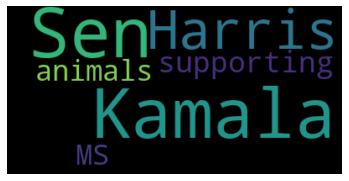

In [112]:
# generate word cloud for first statement
text = df.statement[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Uncomment to save file
#wordcloud.to_file("all_doc_cloud.png")

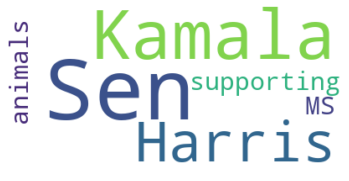

In [113]:
# changing settings
wordcloud = WordCloud(min_font_size=30, 
                      max_font_size=100, 
                      max_words=20, 
                      background_color="white").generate(text)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [114]:
# wordcloud generator function function 
def word_cloud(df, column, max_words=20):
    
    # Combine documents
    text = " ".join( _ for _ in column)
    
    # Sanity check
    print ("There are", len(text) ,"words")

    # Generate image
    plt.figure(figsize=(10, 8))
    wordcloud = WordCloud(min_font_size=5, 
                          max_font_size=60, 
                          max_words=max_words, 
                          background_color="white").generate(text)

    # Display the generated image
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## Truth Word Cloud

#### For the statement column

There are 537144 words


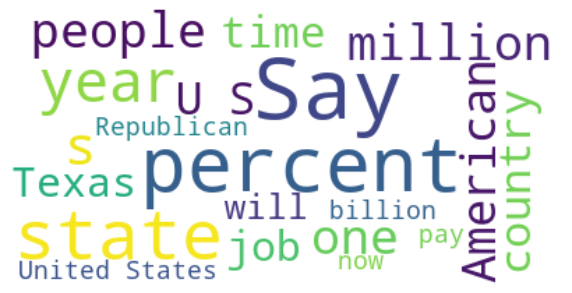

In [115]:
word_cloud(df, df[df.veracity == 1]["statement"])

#### For the lemmas column

There are 311977 words


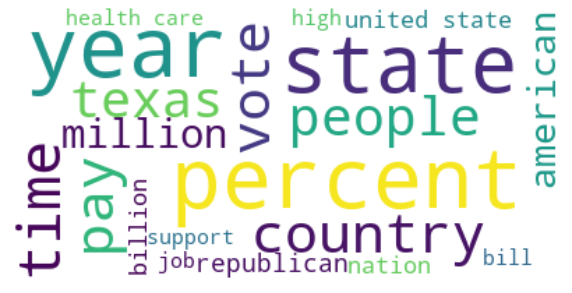

In [116]:
word_cloud(df, df[df.veracity == 1]["lemmas"])

## False Word Cloud

#### For the statement column

There are 681547 words


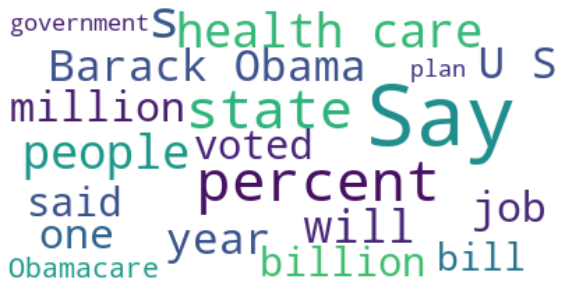

In [117]:
word_cloud(df, df[df.veracity == 0]["statement"])

#### For the lemmas column

There are 410895 words


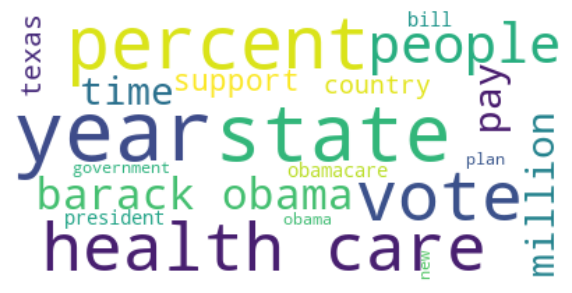

In [118]:
word_cloud(df, df[df.veracity == 0]["lemmas"])

### Import another dataset to check Pants on Fire

In [119]:
df = pd.read_csv("politifact_clean.csv")
df.head()

,statement,source,link,veracity
0,"Sen. Kamala Harris is ""supporting the animals of MS-13.""",Donald Trump,/web/20180705082623/https://www.politifact.com/california/statements/2018/jul/03/donald-trump/pants-fire-white-house-claim-sen-harris-supporting/,Pants on Fire!
1,"Says Ronald Reagan said immigrants ""brought with them courage and the values of family, work, and freedom. Let us pledge to each other that we can make America great again.""",Becoming American Initiative,/web/20180705082623/https://www.politifact.com/truth-o-meter/statements/2018/jul/03/becoming-american-initiative/did-ronald-reagan-say-immigrants-made-america-grea/,Mostly True
2,"Says Democratic Senators ""demand Supreme Court nominee not be unduly influenced by U.S. Constitution.""",Viral image,/web/20180705082623/https://www.politifact.com/punditfact/statements/2018/jul/03/viral-image/viral-image-criticizing-democrats-featured-fabrica/,Pants on Fire!
3,"""Tim Kaine doesn’t want a border at all. He wants to get rid of Immigration and Customs Enforcement and basically the border patrol as well.""",Corey Stewart,/web/20180705082623/https://www.politifact.com/truth-o-meter/statements/2018/jul/03/corey-stewart/corey-stewart-falsely-claims-sen-tim-kaine-wants-d/,Pants on Fire!
4,"""George H.W. Bush has died at 94.""",Bloggers,/web/20180705082623/https://www.politifact.com/punditfact/statements/2018/jul/02/blog-posting/hoax-website-says-george-h-w-bush-died-he-didnt/,Pants on Fire!


There are 139192 words


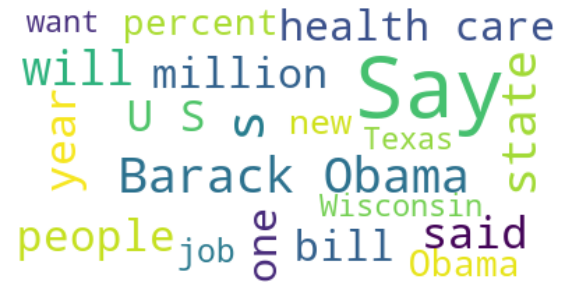

In [120]:
word_cloud(df, df[df.veracity == "Pants on Fire!"]["statement"])